In [ ]:
pip install prophet 

     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 179 kB 9.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640267 sha256=4c501492df01797ee832eb9002f20b987b6a0754314b37761b1b8768b7b5d9a7
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 9.5 MB 19.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [61]:
# importing used libraries 
 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from fbprophet import Prophet
import math
from pmdarima import auto_arima
sns.set()

**1) Opening Data & Cleaning**

In [79]:
#Reading Data for the Indego Trips from Q1 of 2018
pd.to_datetime
data_bikes = pd.read_csv('indego-trips-2018-q1.csv')
data_holidays = pd.read_excel('Holidays_Philadelphia_2018.xlsx')
data_stations = pd.read_csv('indego-stations-2021-01-01.csv')
data_prices = pd.read_excel('Indego Prices 2018.xlsx')
data_weather = pd.read_csv('weather_hourly_philadelphia (1).csv')

In [80]:
# Our objective now will be to join all the datasets that we have
# We first add holidays info to data_bikes:
# We join the two datasets on dates, so we change the dates formats so they will be identical
data_holidays['date'] = pd.to_datetime(data_holidays.date, format='yy/mm/dd')
 
data_bikes['start_time'] = pd.to_datetime(data_bikes.start_time)
data_bikes['end_time'] = pd.to_datetime(data_bikes.end_time)
 
# Creation of a new column date to indicate the date of bike rental 
data_bikes['date'] = data_bikes['start_time'].dt.normalize()
 
# Merging holidays data and data_bikes data on date:
data_all = pd.merge(data_bikes, data_holidays, on='date', how='outer')
data_all = data_all[~data_all.trip_id.isna()]

In [81]:
data_all

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,date,day_type
0,223869188.0,18.0,2018-01-01 00:24:00,2018-01-01 00:42:00,3124.0,39.952950,-75.139793,3073.0,39.961430,-75.152420,3708.0,30.0,One Way,Indego30,2018-01-01,holiday
1,223905597.0,572.0,2018-01-01 00:38:00,2018-01-01 10:10:00,3023.0,39.950481,-75.172859,3066.0,39.945610,-75.173477,3288.0,365.0,One Way,Indego365,2018-01-01,holiday
2,223872811.0,22.0,2018-01-01 00:48:00,2018-01-01 01:10:00,3026.0,39.941380,-75.145638,3023.0,39.950481,-75.172859,11735.0,30.0,One Way,Indego30,2018-01-01,holiday
3,223872810.0,21.0,2018-01-01 01:03:00,2018-01-01 01:24:00,3045.0,39.947922,-75.162369,3037.0,39.954239,-75.161377,5202.0,30.0,One Way,Indego30,2018-01-01,holiday
4,223872809.0,4.0,2018-01-01 01:05:00,2018-01-01 01:09:00,3115.0,39.972630,-75.167572,3058.0,39.967159,-75.170013,5142.0,30.0,One Way,Indego30,2018-01-01,holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98988,241464155.0,4.0,2018-03-31 23:51:00,2018-03-31 23:55:00,3018.0,39.952728,-75.159790,3154.0,39.959240,-75.158211,11884.0,30.0,One Way,Indego30,2018-03-31,normal
98989,241475857.0,12.0,2018-03-31 23:52:00,2018-04-01 00:04:00,3004.0,39.953781,-75.163742,3032.0,39.945271,-75.179710,11953.0,365.0,One Way,Indego365,2018-03-31,normal
98990,241475858.0,11.0,2018-03-31 23:52:00,2018-04-01 00:03:00,3028.0,39.940609,-75.149582,3034.0,39.933151,-75.162483,11827.0,30.0,One Way,Indego30,2018-03-31,normal
98991,241475859.0,11.0,2018-03-31 23:52:00,2018-04-01 00:03:00,3028.0,39.940609,-75.149582,3034.0,39.933151,-75.162483,11734.0,30.0,One Way,Indego30,2018-03-31,normal


In [82]:
print(data_all.head())
print(len(data_all), len(data_bikes))

       trip_id  duration          start_time            end_time  \
0  223869188.0      18.0 2018-01-01 00:24:00 2018-01-01 00:42:00   
1  223905597.0     572.0 2018-01-01 00:38:00 2018-01-01 10:10:00   
2  223872811.0      22.0 2018-01-01 00:48:00 2018-01-01 01:10:00   
3  223872810.0      21.0 2018-01-01 01:03:00 2018-01-01 01:24:00   
4  223872809.0       4.0 2018-01-01 01:05:00 2018-01-01 01:09:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0         3124.0  39.952950 -75.139793       3073.0  39.961430 -75.152420   
1         3023.0  39.950481 -75.172859       3066.0  39.945610 -75.173477   
2         3026.0  39.941380 -75.145638       3023.0  39.950481 -75.172859   
3         3045.0  39.947922 -75.162369       3037.0  39.954239 -75.161377   
4         3115.0  39.972630 -75.167572       3058.0  39.967159 -75.170013   

   bike_id  plan_duration trip_route_category passholder_type       date  \
0   3708.0           30.0             One Way       

In [66]:
# We then add information on stations
print(data_stations.dtypes)
data_all['start_station'] = data_all['start_station'].astype('int64')
data_all['end_station'] = data_all['end_station'].astype('int64')

Station_ID       int64
Station_Name    object
Go_live_date    object
Status          object
dtype: object


In [67]:
data_stations['Go_live_date'] = pd.to_datetime(data_stations.Go_live_date)
data_stations_start = data_stations.copy()
data_stations_start.columns = ['start_station', 'Start_station_name', 'Go_live_station_start', 'status_start']

In [68]:
data_all = pd.merge(data_all, data_stations_start, on='start_station', how='outer')
data_all = data_all[~data_all.trip_id.isna()]

In [69]:
data_stations_end = data_stations.copy()
data_stations_end.columns = ['end_station', 'End_station_name', 'Go_live_station_end', 'status_end']

In [70]:
data_all = pd.merge(data_all, data_stations_end, on='end_station', how='outer')
data_all = data_all[~data_all.trip_id.isna()]

In [71]:
data_all['start_time_hour'] = pd.Series(data_all.start_time).dt.round("H")
data_all['end_time_hour'] = pd.Series(data_all.end_time).dt.round("H")

In [72]:
# Joining Weather information 
data_weather['date_time'] = pd.to_datetime(data_wether['date_time'])

In [73]:
data_weather_start, data_weather_end = data_weather.copy(), data_weather.copy()
 
data_weather_start.columns = ['start_time_hour', 'max_temp_start', 'min_temp_start', 'precip_start']
data_weather_end.columns = ['end_time_hour', 'max_temp_end', 'min_temp_end', 'precip_end']

In [74]:

data_all = pd.merge(data_all, data_weather_start, on='start_time_hour', how='outer')
data_all = data_all[~data_all.trip_id.isna()].drop_duplicates(subset='trip_id', keep="last")

In [75]:
data_all = pd.merge(data_all, data_weather_end, on='end_time_hour', how='outer')
data_all = data_all[~data_all.trip_id.isna()].drop_duplicates(subset='trip_id', keep="last")

In [20]:
data_all

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,Go_live_station_end,status_end,start_time_hour,end_time_hour,max_temp_start,min_temp_start,precip_start,max_temp_end,min_temp_end,precip_end
0,223869188.0,18.0,2018-01-01 00:24:00,2018-01-01 00:42:00,3124.0,39.952950,-75.139793,3073.0,39.961430,-75.152420,...,2015-04-28,Active,2018-01-01 00:00:00,2018-01-01 01:00:00,-10.6,-10.6,0.0,-10.6,-10.6,0.0
1,223872810.0,21.0,2018-01-01 01:03:00,2018-01-01 01:24:00,3045.0,39.947922,-75.162369,3037.0,39.954239,-75.161377,...,2015-04-29,Active,2018-01-01 01:00:00,2018-01-01 01:00:00,-10.6,-10.6,0.0,-10.6,-10.6,0.0
2,223872811.0,22.0,2018-01-01 00:48:00,2018-01-01 01:10:00,3026.0,39.941380,-75.145638,3023.0,39.950481,-75.172859,...,2015-04-23,Inactive,2018-01-01 01:00:00,2018-01-01 01:00:00,-10.6,-10.6,0.0,-10.6,-10.6,0.0
3,223872809.0,4.0,2018-01-01 01:05:00,2018-01-01 01:09:00,3115.0,39.972630,-75.167572,3058.0,39.967159,-75.170013,...,2015-04-23,Active,2018-01-01 01:00:00,2018-01-01 01:00:00,-10.6,-10.6,0.0,-10.6,-10.6,0.0
4,226579697.0,20.0,2018-01-22 17:10:00,2018-01-22 17:30:00,3124.0,39.952950,-75.139793,3073.0,39.961430,-75.152420,...,2015-04-28,Active,2018-01-22 17:00:00,2018-01-22 18:00:00,12.2,12.2,0.0,13.9,13.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104289,237724441.0,4.0,2018-03-15 02:07:00,2018-03-15 02:11:00,3009.0,39.955761,-75.189819,3160.0,39.956619,-75.198624,...,2017-06-06,Active,2018-03-15 02:00:00,2018-03-15 02:00:00,1.7,1.7,0.0,1.7,1.7,0.0
104290,237715814.0,11.0,2018-03-15 01:32:00,2018-03-15 01:43:00,3023.0,39.950481,-75.172859,3075.0,39.967178,-75.161247,...,2015-04-28,Active,2018-03-15 02:00:00,2018-03-15 02:00:00,1.7,1.7,0.0,1.7,1.7,0.0
104291,239348803.0,13.0,2018-03-22 02:45:00,2018-03-22 02:58:00,3035.0,39.962711,-75.194191,3120.0,39.975220,-75.186691,...,2016-04-26,Active,2018-03-22 03:00:00,2018-03-22 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
104292,231033224.0,28.0,2018-02-12 02:30:00,2018-02-12 02:58:00,3058.0,39.967159,-75.170013,3075.0,39.967178,-75.161247,...,2015-04-28,Active,2018-02-12 02:00:00,2018-02-12 03:00:00,17.8,17.2,0.0,17.2,17.2,0.0


In [21]:
data_all.start_time.max()

Timestamp('2018-03-31 23:54:00')

In [22]:
data_all.start_time.min()

Timestamp('2018-01-01 00:24:00')

a. Solving the missing values problem

In [23]:
missing_data = (data_all.isna().sum()/(len(data_all)))*100

Text(0, 0.5, 'Number of variables')

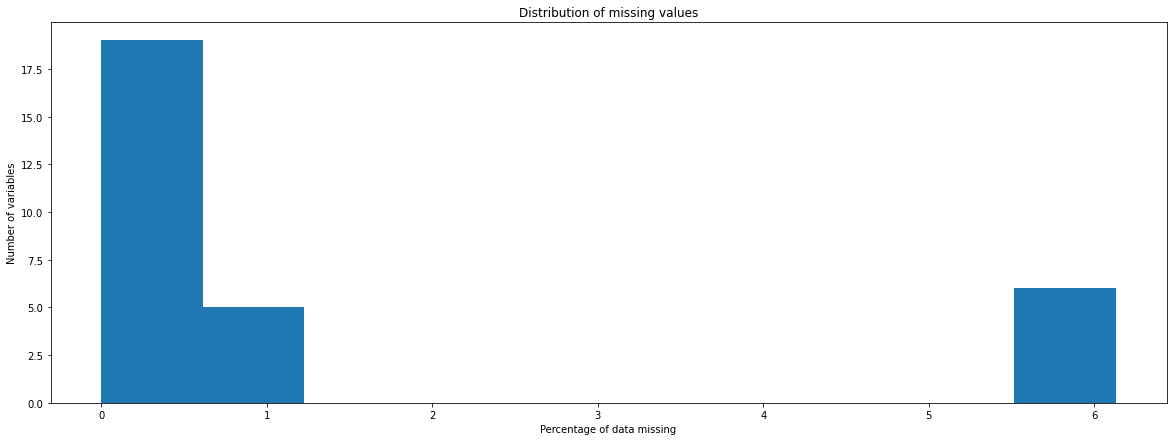

In [24]:

#plotting missing values 
plt.rcParams["figure.figsize"] = (20,7)
missing_data.sort_values(ascending = False).plot.hist()
plt.title('Distribution of missing values')
plt.xlabel('Percentage of data missing')
plt.ylabel('Number of variables')

In [25]:
# Because the percentage of missing values is around 6%, we chose to drop all nan values
data_all = data_all.dropna()
print('The loss of rows due to missing values elimination is given by:', round(100 - (100*len(data_all))/98993, 3),'%')

The loss of rows due to missing values elimination is given by: 8.528 %


**Descriptive Analysis**

In [26]:
# We will be interested here by the evolution of demand for bike rentals as function of time


<AxesSubplot:xlabel='date'>

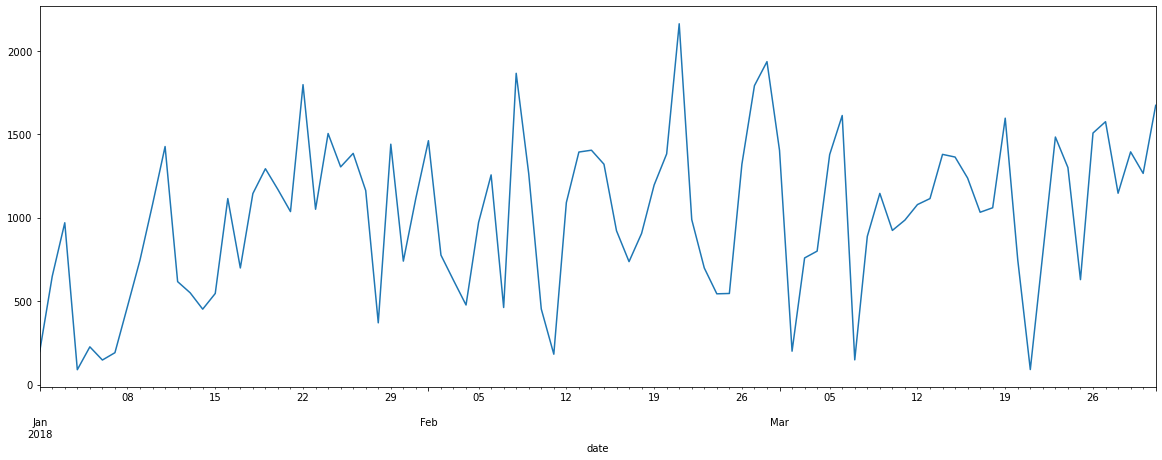

In [27]:
(data_all.groupby('date').trip_id.count()).plot()
# We observe a weekly seasonnality. To better understand the underlying performance, we plot a 7 days rolling average

Text(0.5, 1.0, 'Evolution of daily riders between Jan 2018 and April 2018')

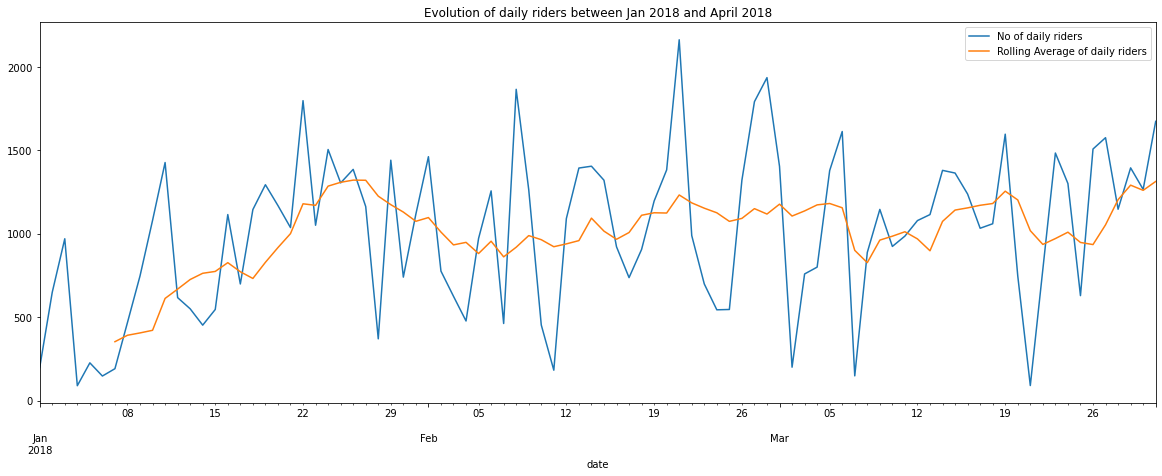

In [28]:
(data_all.groupby('date').trip_id.count()).plot()
(data_all.groupby('date').trip_id.count().rolling(7).mean()).plot()
plt.legend(['No of daily riders','Rolling Average of daily riders'])
plt.title('Evolution of daily riders between Jan 2018 and April 2018')

In [29]:
# Now our objective is to explore the evolution of demand as a function hour of day
data_all['hour_start'] = data_all['start_time'].dt.hour

<ipython-input-29-6c58d4d4fb5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['hour_start'] = data_all['start_time'].dt.hour


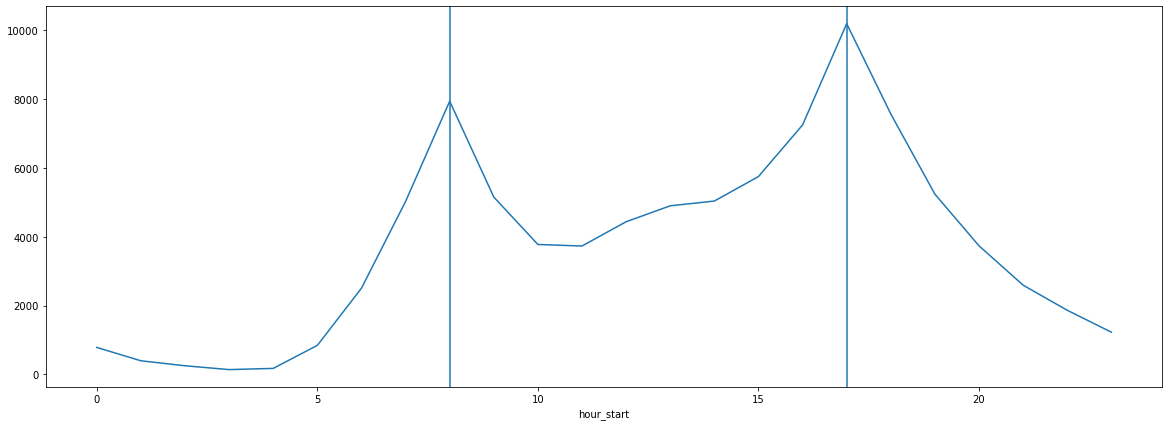

In [30]:
(data_all.groupby('hour_start')['trip_id'].count()).plot()
plt.axvline(x=17)
plt.axvline(x=8)

# The demand plot has two peaks. The first one coincides with 8AM and the second peak is at 5 PM(17h),
# These results are coherant and can be explained work hours: 8h and 17h 

<ipython-input-31-fdaccb4e0e19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['day_start'] = data_all['start_time'].dt.day


<AxesSubplot:xlabel='day_start'>

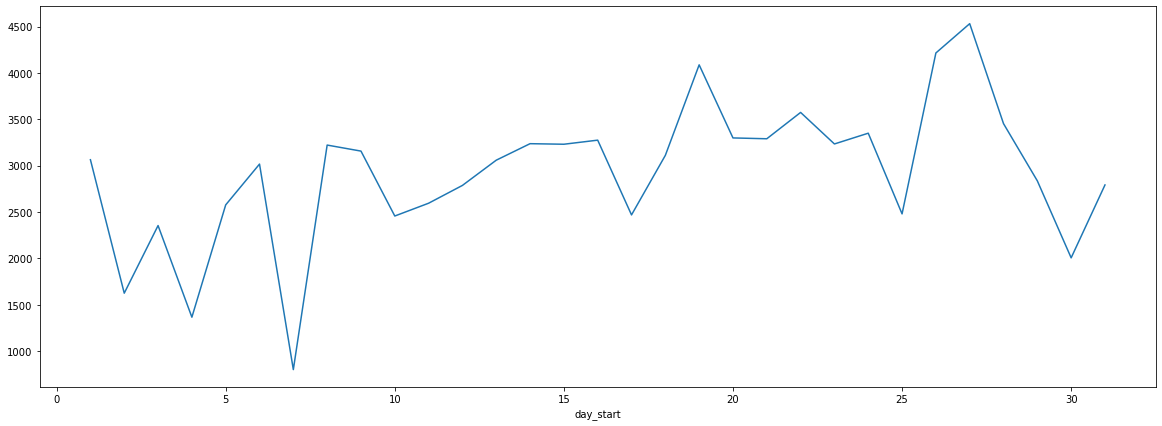

In [31]:
# Now our objective is to explore the evolution of demand as a function the day
data_all['day_start'] = data_all['start_time'].dt.day
 
(data_all.groupby('day_start')['trip_id'].count()).plot()

<ipython-input-32-e55dc5e572c9>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_all['week_start'] = data_all['start_time'].dt.week
<ipython-input-32-e55dc5e572c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['week_start'] = data_all['start_time'].dt.week


<AxesSubplot:xlabel='week_start'>

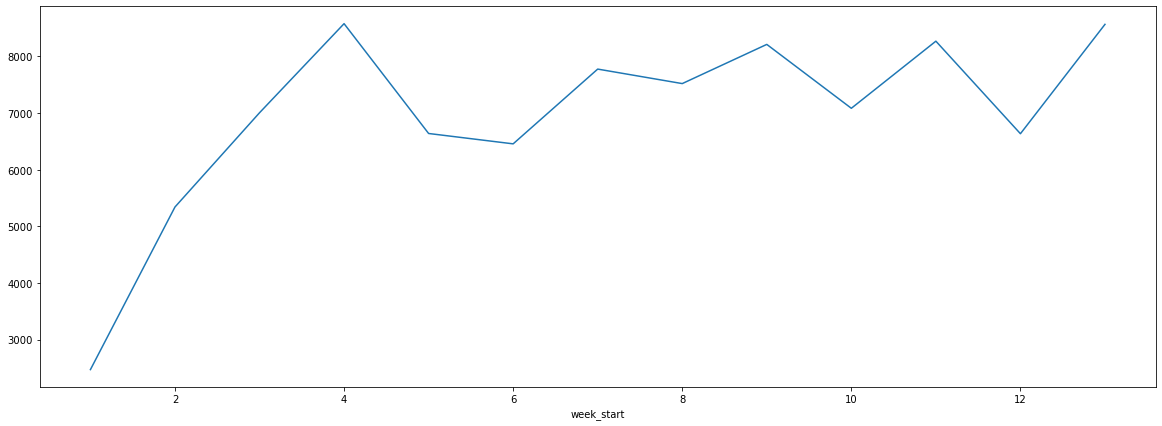

In [32]:
data_all['week_start'] = data_all['start_time'].dt.week

(data_all.groupby('week_start')['trip_id'].count()).plot()


### Key Indicators of Performance

In [33]:
 
# distribution of rides as function of geographical location
data_all.groupby('Start_station_name')['trip_id'].count().sort_values(ascending = False)

Start_station_name
15th & Spruce                        2771
18th & JFK                           2468
Rittenhouse Square                   2119
University City Station              2017
13th & Locust                        1995
                                     ... 
ParkWest Town Center                   70
33rd & Dauphin                         69
Parkside & Belmont, Case Building      68
29th & Dauphin                         55
21st & Winter, Franklin Institute       6
Name: trip_id, Length: 123, dtype: int64

In [34]:
data_all.groupby('End_station_name')['trip_id'].count().sort_values(ascending = False)

End_station_name
18th & JFK                           3163
15th & Spruce                        2789
Rittenhouse Square                   2200
13th & Locust                        1962
Rodin Museum                         1950
                                     ... 
33rd & Diamond                         62
33rd & Dauphin                         56
ParkWest Town Center                   55
29th & Dauphin                         54
21st & Winter, Franklin Institute       5
Name: trip_id, Length: 123, dtype: int64

In [35]:
data_all.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'date', 'day_type', 'Start_station_name', 'Go_live_station_start',
       'status_start', 'End_station_name', 'Go_live_station_end', 'status_end',
       'start_time_hour', 'end_time_hour', 'max_temp_start', 'min_temp_start',
       'precip_start', 'max_temp_end', 'min_temp_end', 'precip_end',
       'hour_start', 'day_start', 'week_start'],
      dtype='object')

In [36]:
# Average trip duration during Q1 of 2018
# Creation of a column containing the duration of the trip
data_all['duration'] = (data_all['end_time'] - data_all['start_time']).astype('timedelta64[m]')

<ipython-input-36-2c054ee74516>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['duration'] = (data_all['end_time'] - data_all['start_time']).astype('timedelta64[m]')


In [37]:
# Average period and standard deviation of riding period
average_time = round(data_all['duration'].mean(), 4)
std_time = round(data_all['duration'].std(), 4)
print('The average duration of a trip is:', str(average_time), 'with a standard deviation of ±', str(std_time))

The average duration of a trip is: 16.7047 with a standard deviation of ± 60.2843


We see an important heterogenity when it comes to riding duration, as the standard deviation is significant. This might imply that the prediction task must include the maximum variables that we can use to better explain riders behavior.

### Average daily attendance per month

In [38]:
data_all['month'] = data_all.start_time.dt.month
monthly_rides = data_all.groupby('month').trip_id.count()
monthly_rides = pd.DataFrame(monthly_rides)
monthly_rides.columns = ['No of Rides']
print(monthly_rides)

       No of Rides
month             
1            26693
2            30141
3            33717


<ipython-input-38-46fd47a07211>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['month'] = data_all.start_time.dt.month


In [39]:
# Impact of weather (Here one would expect that the weather conditions should impact the business)
 
precipitation = pd.DataFrame(data_all.groupby('precip_start').trip_id.count())
precipitation.index = ['No_precipitation', 'Precipitation']
precipitation.columns = ['No of Rides']
print(precipitation)

                  No of Rides
No_precipitation        84094
Precipitation            6457


In [40]:
 precipitation = pd.DataFrame(data_all.groupby('precip_start').trip_id.count())
precipitation.index = ['No_precipitation', 'Precipitation']
precipitation.columns = ['No of Rides']
print(precipitation)

                  No of Rides
No_precipitation        84094
Precipitation            6457


In [41]:
pd.DataFrame(data_all[['precip_start', 'start_time_hour']].drop_duplicates()).value_counts()

precip_start  start_time_hour    
1.0           2018-03-30 19:00:00    1
0.0           2018-02-03 15:00:00    1
              2018-02-01 23:00:00    1
              2018-02-02 00:00:00    1
              2018-02-02 01:00:00    1
                                    ..
              2018-03-11 04:00:00    1
              2018-03-11 05:00:00    1
              2018-03-11 06:00:00    1
              2018-03-11 07:00:00    1
              2018-01-01 00:00:00    1
Length: 1940, dtype: int64

In [42]:
data_all['Station_age'] = (data_all.start_time.dt.to_period('M').astype(int) - data_all.Go_live_station_start.dt.to_period('M').astype(int))
 
print('Average station age at day of ride:', round(data_all['Station_age'].mean(), 4), 'Months')

Average station age at day of ride: 28.8195 Months


<ipython-input-42-8edb2665ddd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Station_age'] = (data_all.start_time.dt.to_period('M').astype(int) - data_all.Go_live_station_start.dt.to_period('M').astype(int))


### Predictions

<AxesSubplot:xlabel='start_time_hour'>

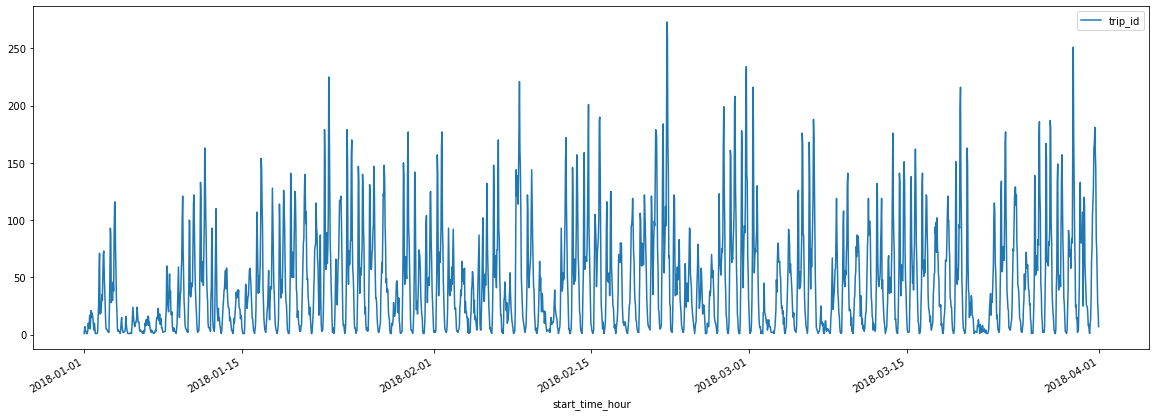

In [43]:

# aggregation of number of rides on an hourly basis 
data_hourly = pd.DataFrame(data_all.groupby('start_time_hour').trip_id.count())
data_hourly.plot()

<ipython-input-44-e53d2c587808>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  seasonal_decompose(data_hourly, freq = 24).plot()


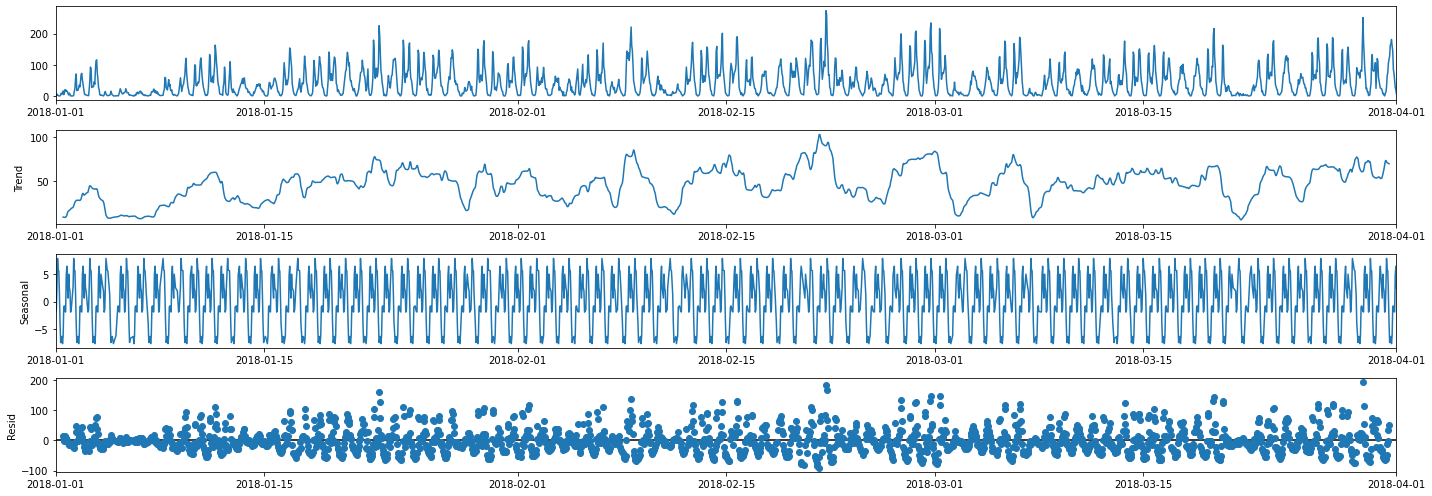

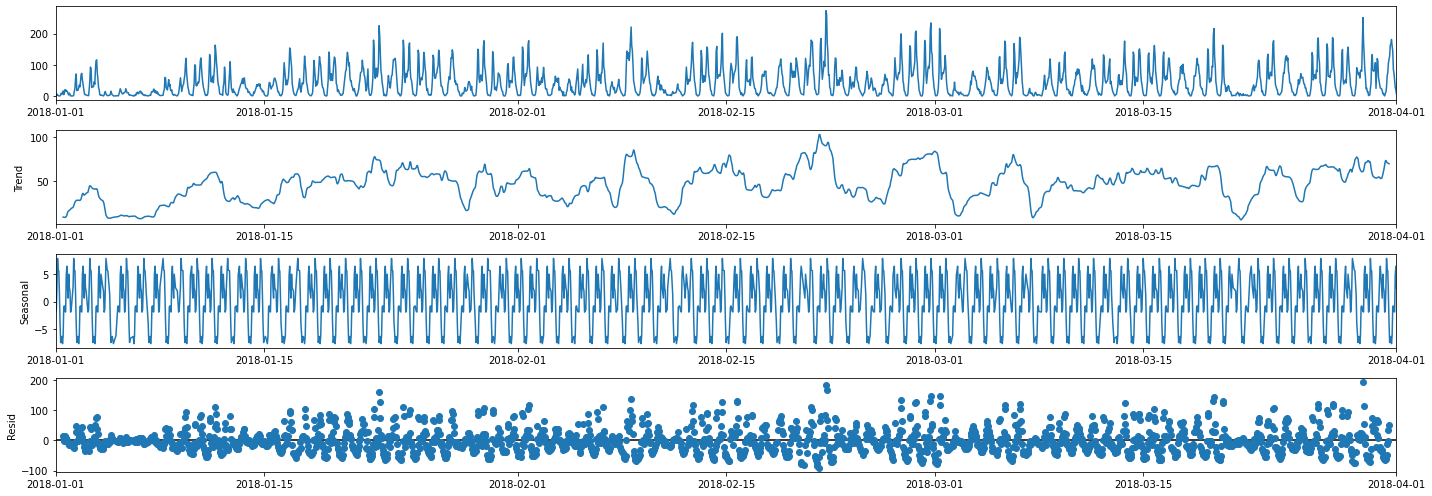

In [44]:
# we decompose the Time Serie into trend and seasonality in order to better understand the dynamics 
# We observe a 24 hours seasonality 
seasonal_decompose(data_hourly, freq = 24).plot()

#### SARIMA

In [45]:
 
# The first model is a SARIMA model. We thought that transforming it with log would increase the fit of the model
# We divide the dataset into training and testing sets: 2/3 for the training and 1/3 for the testing. The order is preserved.
log_data = np.log(data_hourly)
data_train = log_data.iloc[:math.floor((2/3)*len(log_data))]
data_test = log_data.iloc[math.floor((2/3)*len(log_data)):]

In [ ]:
 
# since we don't know what parameters of the SARIMA, we use auto_arima function from pmd_arima library to automatically find the optimal parameters 
Sarima_model = auto_arima(data_train['trip_id'],
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=24,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: ignored

In [46]:
model = sm.tsa.statespace.SARIMAX(data_train['trip_id'],order=(3, 0, 0),
              seasonal_order=(2, 1, 0, 24),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [47]:
 
# we forecast with the fitted model
forecast = results.predict(start = len(data_train)+1,
                           end=len(data_train)+len(data_test),
                           typ='levels')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [48]:
forecast = pd.DataFrame(forecast)
forecast.index = data_test.index
forecast = np.exp(forecast)

In [49]:
data_test

,trip_id
start_time_hour,
2018-03-02 17:00:00,2.484907
2018-03-02 18:00:00,2.564949
2018-03-02 19:00:00,1.945910
2018-03-02 21:00:00,1.945910
2018-03-02 22:00:00,1.386294
...,...
2018-03-31 20:00:00,4.290459
2018-03-31 21:00:00,3.931826
2018-03-31 22:00:00,3.332205


In [50]:

# getting the RMSE metric for the model
se = np.square(np.exp(data_test).trip_id - forecast.predicted_mean)
mse = se.mean()
rmse = np.sqrt(mse)

In [51]:

# We believe that we can improve a little more the performance. We this implement other models
print('The RMSE score for the prediction is', round(rmse, 4))

The RMSE score for the prediction is 71.2677


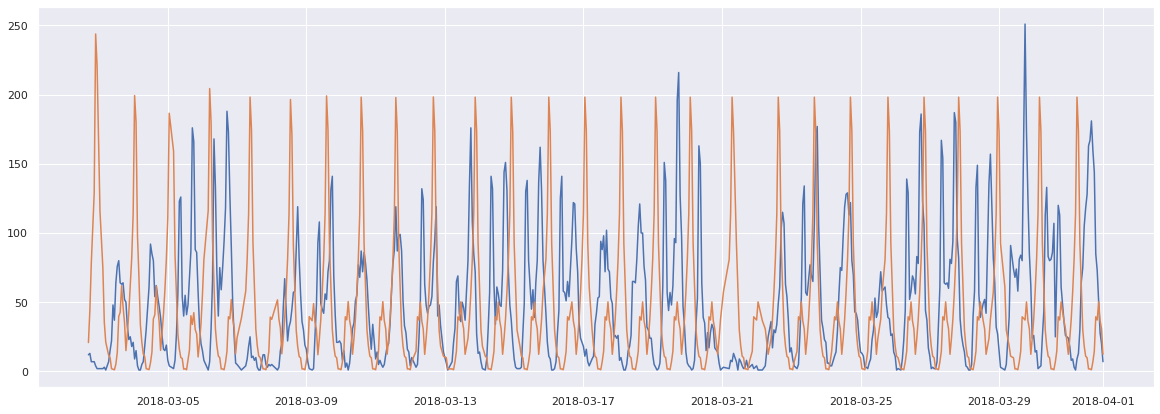

In [52]:
plt.plot(np.exp(data_test))
plt.plot(forecast)

### FB Prophet

In [53]:

# here, we implement the Facebook prophet 
data_hourly

,trip_id
start_time_hour,
2018-01-01 00:00:00,1
2018-01-01 01:00:00,4
2018-01-01 02:00:00,7
2018-01-01 03:00:00,3
2018-01-01 04:00:00,3
...,...
2018-03-31 20:00:00,73
2018-03-31 21:00:00,51
2018-03-31 22:00:00,28


In [54]:
# Preparing Data
# changing column names so fb prophet can fit data 
data_prediction_fb = data_hourly.reset_index().rename(columns={'start_time_hour':'ds', 'trip_id':'y'})
data_train = data_prediction_fb.iloc[:math.floor((2/3)*len(data_prediction_fb))]
data_test = data_prediction_fb.iloc[math.floor((2/3)*len(data_prediction_fb)):]

In [55]:
len(data_test)

647

In [56]:

# calling FB prophet and fitting data
m = Prophet()
m.fit(data_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [57]:
 
#create future dates. The number of future dates coincides with the number of dates generated
future_dates = m.make_future_dataframe(periods=647, freq='h')

In [58]:

# predict values for the created future dates 
forecast = m.predict(future_dates,)

In [59]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,8.013812,-67.190928,3.951103,8.013812,8.013812,-40.756613,-40.756613,-40.756613,-30.048238,-30.048238,-30.048238,-10.708375,-10.708375,-10.708375,0.0,0.0,0.0,-32.742801
1,2018-01-01 01:00:00,8.100961,-71.618161,5.444391,8.100961,8.100961,-41.203177,-41.203177,-41.203177,-31.572393,-31.572393,-31.572393,-9.630784,-9.630784,-9.630784,0.0,0.0,0.0,-33.102217
2,2018-01-01 02:00:00,8.188109,-74.829852,0.368229,8.188109,8.188109,-47.049765,-47.049765,-47.049765,-38.518341,-38.518341,-38.518341,-8.531425,-8.531425,-8.531425,0.0,0.0,0.0,-38.861656
3,2018-01-01 03:00:00,8.275258,-84.996846,-12.169439,8.275258,8.275258,-55.122600,-55.122600,-55.122600,-47.705446,-47.705446,-47.705446,-7.417154,-7.417154,-7.417154,0.0,0.0,0.0,-46.847342
4,2018-01-01 04:00:00,8.362407,-83.141516,-8.629385,8.362407,8.362407,-56.898419,-56.898419,-56.898419,-50.603513,-50.603513,-50.603513,-6.294906,-6.294906,-6.294906,0.0,0.0,0.0,-48.536012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,2018-03-29 10:00:00,64.075589,57.239302,136.207399,52.808369,75.513736,31.285076,31.285076,31.285076,18.713217,18.713217,18.713217,12.571860,12.571860,12.571860,0.0,0.0,0.0,95.360666
1936,2018-03-29 11:00:00,64.090219,41.870773,118.635094,52.800230,75.566741,17.294455,17.294455,17.294455,5.369179,5.369179,5.369179,11.925277,11.925277,11.925277,0.0,0.0,0.0,81.384674
1937,2018-03-29 12:00:00,64.104848,29.920312,111.857976,52.792383,75.618593,8.614410,8.614410,8.614410,-2.628373,-2.628373,-2.628373,11.242783,11.242783,11.242783,0.0,0.0,0.0,72.719258
1938,2018-03-29 13:00:00,64.119478,32.815762,113.063799,52.784536,75.673000,9.861415,9.861415,9.861415,-0.667407,-0.667407,-0.667407,10.528822,10.528822,10.528822,0.0,0.0,0.0,73.980893


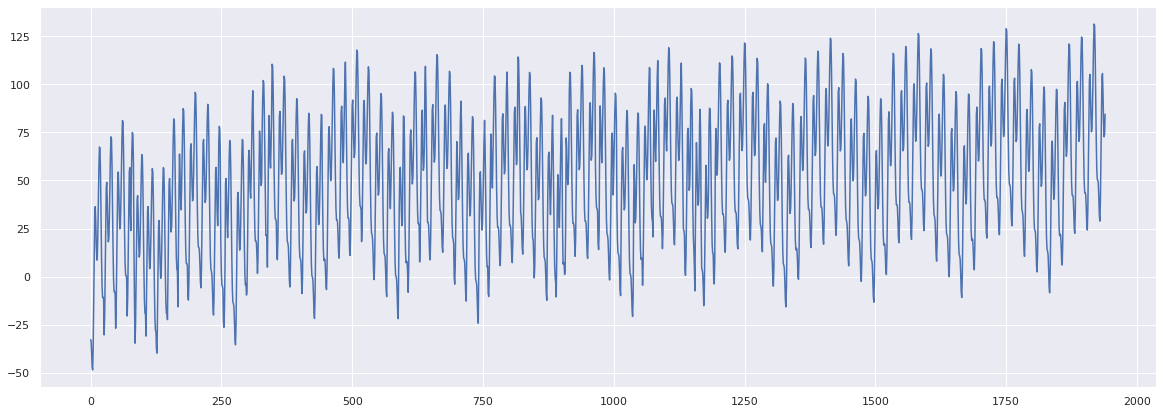

In [60]:
forecast.yhat.plot()

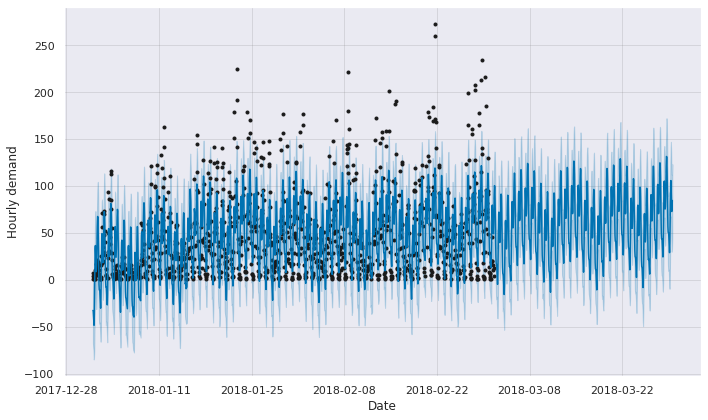

In [61]:

# prediction of the FB prophet model
figure = m.plot(forecast, xlabel='Date', ylabel='Hourly demand')

In [62]:
predictions = forecast.loc[1293:, 'yhat']

In [63]:
se = np.square(predictions - data_test.y )
mse = se.mean()
rmse = np.sqrt(mse)

In [64]:

# the performance had significantly improved. SARIMAX with exogenous variables might improve the results more.
print(rmse)

54.14709952084231


### SARIMA with exogenous variables

In [67]:
 
# now we fit data for SARIMAX 
data_hourly = pd.DataFrame(data_all.groupby('start_time_hour').trip_id.count())

In [68]:
data_hourly.columns = ['No of rides']

In [69]:

# we include 2 exogenous variables:précipitation and the boolean variable indicating if the current day is a holiday
data_exo = data_all[['start_time_hour', 'precip_start', 'day_type']].drop_duplicates()
data_exo.set_index('start_time_hour', inplace = True)
data_exo = data_exo.join(data_hourly).dropna()
data_exo.reset_index(inplace = True)

In [70]:
 
# transformation of the variable 
data_exo['day_type'] = data_exo.day_type.replace({'holiday': 1, 'normal':0})

In [71]:
data_exo_train = data_exo.iloc[:math.floor((2/3)*len(data_exo))]
data_exo_test = data_exo.iloc[math.floor((2/3)*len(data_exo)):]

data_y_train = data_exo_train['No of rides']
data_y_test = data_exo_test['No of rides']

data_exogenous_train = data_exo_train[['precip_start', 'day_type']]
data_exogenous_test = data_exo_test[['precip_start', 'day_type']]


In [ ]:
sarimax = sm.tsa.statespace.SARIMAX(data_y_train,order=(3, 0, 0),
              seasonal_order=(2, 1, 0, 24),exog = data_exogenous_train,
                                enforce_stationarity=False, enforce_invertibility=False).fit()
sarimax.summary()


In [ ]:
predicted_sarimax = sarimax.predict(len(data_exogenous_train),
                           end=len(data_exogenous_train)+len(data_exogenous_test)-1,exog=data_exogenous_test, typ='levels')


In [ ]:
se = np.square(predicted_sarimax - data_y_test)
mse = se.mean()
rmse = np.sqrt(mse)

In [ ]:
print('The value of RMSE is given by', round(rmse, 4))